In [1]:
%pylab inline

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import argparse
import os
from collections import defaultdict

import torch

from habitat.config import Config as CN
from habitat.utils.visualizations.utils import images_to_video, observations_to_image

from habitat_baselines.common.baseline_registry import baseline_registry
from habitat_baselines.common.environments import get_env_class, NavRLEnv
from habitat_baselines.config.default import get_config
from habitat_baselines.utils.common import batch_obs, generate_video
from habitat_baselines.utils.env_utils import construct_envs

from my_habitat_baselines.resnet_policy import PointNavResNetPolicy

In [3]:
jupyter_dir = "/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter"

jupyter_dir

'/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter'

In [4]:
#
# specify args
#

model_path = "/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/models"

arg_string = ""

arg_string += "--model-path %s" % model_path

arg_string += \
"""
--sensors RGB_SENSOR
--hidden-size 512
--normalize-visual-inputs 1
--backbone resnet50
--num-recurrent-layers 2
TEST_EPISODE_COUNT 5
TASK_CONFIG.SIMULATOR.NOISE_MODEL.CONTROLLER Proportional
TASK_CONFIG.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER 0.5
TASK_CONFIG.SIMULATOR.RGB_SENSOR.HFOV 45
TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.HFOV 45
TASK_CONFIG.SIMULATOR.TURN_ANGLE 30
TASK_CONFIG.SIMULATOR.AGENT_0.RADIUS 0.20
TASK_CONFIG.DATASET.DATA_PATH obstacle_1/{split}/{split}.json.gz
TASK_CONFIG.DATASET.SPLIT minival
TASK_CONFIG.ENVIRONMENT.GENERATE_ON_FLY False
TASK_CONFIG.SIMULATOR.RGB_SENSOR.POSITION [0,0.6096,0]
TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.POSITION [0,0.6096,0]
VIDEO_OPTION ['disk']
TASK_CONFIG.TASK.TOP_DOWN_MAP.MAP_RESOLUTION 5000
"""

print(arg_string)

parser = argparse.ArgumentParser()
parser.add_argument("--model-path", type=str, required=True)
parser.add_argument("--sensors", type=str, required=True)
parser.add_argument("--hidden-size", type=int, required=True)
parser.add_argument(
    "--normalize-visual-inputs", type=int, required=True, choices=[0, 1]
)
parser.add_argument(
    "--backbone",
    type=str,
    required=True,
    choices=["resnet50", "se_resneXt50"],
)
parser.add_argument("--num-recurrent-layers", type=int, required=True)
parser.add_argument(
    "opts",
    default=None,
    nargs=argparse.REMAINDER,
    help="Modify config options from command line",
)
args = parser.parse_args(arg_string.split())

print(args)

--model-path /Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/models
--sensors RGB_SENSOR
--hidden-size 512
--normalize-visual-inputs 1
--backbone resnet50
--num-recurrent-layers 2
TEST_EPISODE_COUNT 5
TASK_CONFIG.SIMULATOR.NOISE_MODEL.CONTROLLER Proportional
TASK_CONFIG.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER 0.5
TASK_CONFIG.SIMULATOR.RGB_SENSOR.HFOV 45
TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.HFOV 45
TASK_CONFIG.SIMULATOR.TURN_ANGLE 30
TASK_CONFIG.SIMULATOR.AGENT_0.RADIUS 0.20
TASK_CONFIG.DATASET.DATA_PATH obstacle_1/{split}/{split}.json.gz
TASK_CONFIG.DATASET.SPLIT minival
TASK_CONFIG.ENVIRONMENT.GENERATE_ON_FLY False
TASK_CONFIG.SIMULATOR.RGB_SENSOR.POSITION [0,0.6096,0]
TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.POSITION [0,0.6096,0]
VIDEO_OPTION ['disk']
TASK_CONFIG.TASK.TOP_DOWN_MAP.MAP_RESOLUTION 5000

Namespace(backbone='resnet50', hidden_size=512, model_path='/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/models', normalize_visual_inputs=1, num_re

In [5]:
#
# load and customize config
#

habitat_dir = "/Users/mroberts/code/github/habitat-lab"
os.chdir(habitat_dir)

config = get_config(
    "habitat_baselines/config/pointnav/ppo_pointnav.yaml"
)

config.defrost()
config.TASK_CONFIG.SIMULATOR.NOISE_MODEL = CN()
config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.CONTROLLER = None
config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER = None
config.TASK_CONFIG.SIMULATOR.RGB_SENSOR.HFOV = None
config.TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.HFOV = None
config.TASK_CONFIG.ENVIRONMENT.GENERATE_ON_FLY = None
config.freeze()

config.merge_from_list(args.opts)

config.defrost()
# config.TASK_CONFIG.SIMULATOR.ACTION_SPACE_CONFIG = "pyrobotnoisy"
config.freeze()

config.defrost()
config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.ROBOT = "LoCoBot"
# config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.CONTROLLER = "ILQR"    # our pre-trained model lists "proportional" in the filename, so don't change to ILQR 
# config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER = 1.0 # our pre-trained model lists "0.5" in the filename, so don't change to 1.0
config.freeze()

config.defrost()
config.TASK_CONFIG.DATASET.CONTENT_SCENES = ["*"]
config.TASK_CONFIG.DATASET.DATA_PATH = "data/datasets/pointnav/gibson/v2/val/val.json.gz" # don't have obstacle_1 scenes, so use Gibson instead
config.freeze()

config.defrost()
config.NUM_ENVIRONMENTS = 1
config.freeze()

config.defrost()
if args.sensors == "":
    config.SENSORS = []
else:
    config.SENSORS = args.sensors.split(",")
# TODO(akadian): collisions are not working
# config.TASK_CONFIG.TASK.MEASUREMENTS.append("COLLISIONS")
config.freeze()

print(config)

BASE_TASK_CONFIG_PATH: configs/tasks/pointnav_gibson.yaml
CHECKPOINT_FOLDER: data/new_checkpoints
CHECKPOINT_INTERVAL: -1
CMD_TRAILING_OPTS: []
ENV_NAME: NavRLEnv
EVAL:
  SPLIT: val
  USE_CKPT_CONFIG: True
EVAL_CKPT_PATH_DIR: data/new_checkpoints
FORCE_BLIND_POLICY: False
FORCE_TORCH_SINGLE_THREADED: True
LOG_FILE: train.log
LOG_INTERVAL: 25
NUM_CHECKPOINTS: 100
NUM_ENVIRONMENTS: 1
NUM_PROCESSES: -1
NUM_UPDATES: 10000
ORBSLAM2:
  ANGLE_TH: 0.2617993877991494
  BETA: 100
  CAMERA_HEIGHT: 1.25
  DEPTH_DENORM: 10.0
  DIST_REACHED_TH: 0.15
  DIST_TO_STOP: 0.05
  D_OBSTACLE_MAX: 4.0
  D_OBSTACLE_MIN: 0.1
  H_OBSTACLE_MAX: 1.25
  H_OBSTACLE_MIN: 0.375
  MAP_CELL_SIZE: 0.1
  MAP_SIZE: 40
  MIN_PTS_IN_OBSTACLE: 320.0
  NEXT_WAYPOINT_TH: 0.5
  NUM_ACTIONS: 3
  PLANNER_MAX_STEPS: 500
  PREPROCESS_MAP: True
  SLAM_SETTINGS_PATH: habitat_baselines/slambased/data/mp3d3_small1k.yaml
  SLAM_VOCAB_PATH: habitat_baselines/slambased/data/ORBvoc.txt
PROFILING:
  CAPTURE_START_STEP: -1
  NUM_STEPS_TO_CAPT

In [6]:
#
# construct a single env instead of multiple envs for simplicity
#

env = NavRLEnv(config)

2021-11-16 13:02:39,018 Initializing dataset PointNav-v1
2021-11-16 13:02:39,043 initializing sim Sim-v0
I1116 13:02:43.272711 75735 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Sands.navmesh
I1116 13:02:39.046969 179973568 ManagedFileBasedContainer.h:210] <Dataset>::convertFilenameToPassedExt : Filename : default changed to proposed scene_dataset_config.json filename : default.scene_dataset_config.json
I1116 13:02:39.048367 179973568 AttributesManagerBase.h:365] <Dataset>::createFromJsonOrDefaultInternal : Proposing JSON name : default.scene_dataset_config.json from original name : default | This file  does not exist.
I1116 13:02:39.048460 179973568 AssetAttributesManager.cpp:120] Asset attributes (capsule3DSolid : capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created and registered.
I1116 13:02:39.048501 179973568 AssetAttributesManager.cpp:120] Asset attributes (capsule3DWireframe : capsule3DWireframe_hemiRings_8_

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


In [7]:
#
# create device
#

device = (
    torch.device("cuda:{}".format(config.TORCH_GPU_ID))
    if torch.cuda.is_available()
    else torch.device("cpu")
)

device

device(type='cpu')

In [8]:
#
# load model
#

def load_model(
    path,
    observation_space,
    action_space,
    hidden_size,
    normalize_visual_inputs,
    backbone,
    num_recurrent_layers,
    device,
):

    model = PointNavResNetPolicy(
        observation_space=observation_space,
        action_space=action_space,
        hidden_size=hidden_size,
        normalize_visual_inputs=normalize_visual_inputs,
        backbone=backbone,
        num_recurrent_layers=num_recurrent_layers,
        goal_sensor_uuid="pointgoal_with_gps_compass",
    )

    model.to(device)

    new_model_params = sum(
        [torch.numel(p) for _, p in model.named_parameters()]
    )

    saved_model = torch.load(path, map_location=device)
    saved_model_params = sum(
        [torch.numel(v) for k, v in saved_model["state_dict"].items()]
    )

    print(
        "new_model_params: {}, saved_model_params: {}".format(
            new_model_params, saved_model_params
        )
    )

    saved_model_state_dict = {}
    for k, v in saved_model["state_dict"].items():
        new_k = k.replace("actor_critic.", "")
        saved_model_state_dict[new_k] = v

    model.load_state_dict(saved_model_state_dict)

    return model



model_path = \
"/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/models/" + \
"job_19633792"                        + "." \
"sensor_RGB_SENSOR"                   + "." \
"train_data_gibson"                   + "." \
"noise_multiplier_0.5"                + "." \
"noise_model_controller_Proportional" + "." \
"agent_radius_0.20"                   + "." \
"success_reward_10.0"                 + "." \
"slack_reward_-0.01"                  + "." \
"collision_reward_0.0"                + "." \
"spl_max_collisions_500"              + "_" \
"ckpt.000000049"                      + \
".pth"
print(model_path)

action_space = env.action_space
observation_space = env.observation_space

model = load_model(
    path=model_path,
    observation_space=observation_space,
    action_space=action_space,
    hidden_size=args.hidden_size,
    normalize_visual_inputs=bool(args.normalize_visual_inputs),
    backbone=args.backbone,
    num_recurrent_layers=args.num_recurrent_layers,
    device=device,
)

model.eval()

model_params = 0
for k,v in model.state_dict().items():
    # print(k, torch.numel(v))
    model_params += torch.numel(v)
print(model_params)

saved_model = torch.load(model_path, map_location=device)

saved_model_params = 0
for k,v in saved_model["state_dict"].items():
    # print(k, torch.numel(v))
    saved_model_params += torch.numel(v)
print(saved_model_params)

/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/models/job_19633792.sensor_RGB_SENSOR.train_data_gibson.noise_multiplier_0.5.noise_model_controller_Proportional.agent_radius_0.20.success_reward_10.0.slack_reward_-0.01.collision_reward_0.0.spl_max_collisions_500_ckpt.000000049.pth
new_model_params: 12458053, saved_model_params: 12458060
12458060
12458060


DISTANCE_TO_GOAL
DISTANCE_TO: POINT
TYPE: DistanceToGoal
<class 'habitat.tasks.nav.nav.DistanceToGoal'>
distance_to_goal

994

NavigationEpisode(episode_id='11', scene_id='data/scene_datasets/gibson/Sands.glb', start_position=[3.198387861251831, 1.5990136861801147, 0.49142053723335266], start_rotation=[0, 0.912534060483753, 0, -0.4090007193844947], info={'geodesic_distance': 4.263117790222168}, _shortest_path_cache=<habitat_sim._ext.habitat_sim_bindings.MultiGoalShortestPath object at 0x7fb8c9036bf0>, goals=[NavigationGoal(position=[-0.2237996757030487, 1.5990136861801147, -1.2859920263290405], radius=0.2)], start_room=None, shortest_paths=None)

{'distance_to_goal': 4.263117790222168, 'success': 0.0, 'spl': 0.0}

tensor([[0.]])


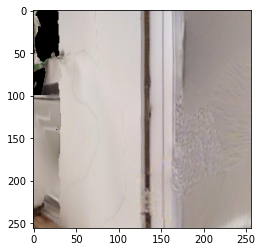

In [9]:
#
# initialization before main loop
#

metric_name = config.TASK_CONFIG.TASK.MEASUREMENTS[0]
metric_cfg = getattr(config.TASK_CONFIG.TASK, metric_name)
measure_type = baseline_registry.get_measure(metric_cfg.TYPE)
metric_uuid = measure_type(None, None)._get_uuid()

assert measure_type is not None, "invalid measurement type {}".format(metric_cfg.TYPE)

print(metric_name)
print(metric_cfg)
print(measure_type)
print(metric_uuid)
print()

observation = env.reset()

print(len(env.episodes))
print()

print(env.current_episode)
print()

print(env._env.get_metrics())
print()

observations = [observation]
batch = batch_obs(observations, device)

num_processes = 1

test_recurrent_hidden_states = torch.zeros(
    model.net.num_recurrent_layers,
    num_processes,
    args.hidden_size,
    device=device,
)
prev_actions = torch.zeros(
    num_processes, 1, device=device, dtype=torch.long
)
not_done_masks = torch.zeros(num_processes, 1, device=device)
print(not_done_masks)

current_episode_num_actions = 0
current_episode_reward = 0.0
current_episode_stats_actions = defaultdict(int)

stats_episodes = dict()  # dict of dicts that stores stats per episode

figsize(4,4)
imshow(observation["rgb"]);

In [10]:
max_num_actions_per_episode = 10000
num_episodes = 994

while len(stats_episodes) < num_episodes:

    #
    # main loop: choose action
    #

    with torch.no_grad():
        _, actions, _, test_recurrent_hidden_states = model.act(
            batch,
            test_recurrent_hidden_states,
            prev_actions,
            not_done_masks,
            deterministic=False,
        )

        prev_actions.copy_(actions)

    assert len(actions) == 1
    action = actions[0]
    
    # print(env.habitat_env.task.get_action_name(action.item()))

    #
    # main loop: perform action
    #

    observation, reward, done, info = env.step(action=action.item())

    #
    # main loop: update state
    #

    observations = [observation]
    batch = batch_obs(observations, device)

    dones = [done]
    not_done_masks = torch.tensor(
        [[0.0] if done else [1.0] for done in dones],
        dtype=torch.float,
        device=device,
    )

    current_episode_num_actions += 1
    current_episode_reward += reward
    current_episode_stats_actions[action.item()] += 1
    
    assert current_episode_num_actions < max_num_actions_per_episode
    
    if done:
        
        # record stats
        stats_episode = dict(info)
        stats_episode["reward"] = current_episode_reward
        stats_episode["stats_actions"] = dict(current_episode_stats_actions)
        
        # if len(stats_episodes) % 100 == 0:
        #     print("Episodes finished: {}".format(len(stats_episodes)))

        print("Episodes finished: {}".format(len(stats_episodes)))

        stats_episodes[ (env.current_episode.scene_id, env.current_episode.episode_id) ] = stats_episode
            
        # reset env
        observation = env.reset()
        observations = [observation]
        batch = batch_obs(observations, device)

        test_recurrent_hidden_states = torch.zeros(
            model.net.num_recurrent_layers,
            num_processes,
            args.hidden_size,
            device=device,
        )
        prev_actions = torch.zeros(
            num_processes, 1, device=device, dtype=torch.long
        )
        not_done_masks = torch.zeros(num_processes, 1, device=device)

        current_episode_num_actions = 0
        current_episode_reward = 0.0
        current_episode_stats_actions = defaultdict(int)

Episodes finished: 0
Episodes finished: 1
Episodes finished: 2
Episodes finished: 3
Episodes finished: 4
Episodes finished: 5
Episodes finished: 6
Episodes finished: 7
Episodes finished: 8
Episodes finished: 9
Episodes finished: 10
Episodes finished: 11
Episodes finished: 12
Episodes finished: 13
Episodes finished: 14
Episodes finished: 15
Episodes finished: 16
Episodes finished: 17
Episodes finished: 18
Episodes finished: 19
Episodes finished: 20
Episodes finished: 21
Episodes finished: 22
Episodes finished: 23
Episodes finished: 24
Episodes finished: 25
Episodes finished: 26
Episodes finished: 27
Episodes finished: 28
Episodes finished: 29
Episodes finished: 30
Episodes finished: 31
Episodes finished: 32
Episodes finished: 33
Episodes finished: 34
Episodes finished: 35
Episodes finished: 36
Episodes finished: 37
Episodes finished: 38
Episodes finished: 39
Episodes finished: 40
Episodes finished: 41
Episodes finished: 42
Episodes finished: 43
Episodes finished: 44
Episodes finished: 4

I1116 13:11:00.597849 75735 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Eastville.navmesh
I1116 13:10:56.819795 179973568 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1116 13:10:56.820863 179973568 SemanticScene.h:43] Deconstructing SemanticScene
I1116 13:10:56.820871 179973568 SceneManager.h:25] Deconstructing SceneManager
I1116 13:10:56.820875 179973568 SceneGraph.h:25] Deconstructing SceneGraph
I1116 13:10:56.821298 179973568 Sensor.cpp:69] Deconstructing Sensor
I1116 13:10:56.881815 179973568 Renderer.cpp:71] Deconstructing Renderer
I1116 13:10:56.883424 179973568 WindowlessContext.h:17] Deconstructing WindowlessContext
I1116 13:10:56.910032 179973568 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Eastville.glb and dataset : default which is currently active dataset.
I1116 13:10:57.030912 179973568 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Fil

Episodes finished: 71
Episodes finished: 72
Episodes finished: 73
Episodes finished: 74
Episodes finished: 75
Episodes finished: 76
Episodes finished: 77
Episodes finished: 78
Episodes finished: 79
Episodes finished: 80
Episodes finished: 81
Episodes finished: 82
Episodes finished: 83
Episodes finished: 84
Episodes finished: 85
Episodes finished: 86
Episodes finished: 87
Episodes finished: 88
Episodes finished: 89
Episodes finished: 90
Episodes finished: 91
Episodes finished: 92
Episodes finished: 93
Episodes finished: 94
Episodes finished: 95
Episodes finished: 96
Episodes finished: 97
Episodes finished: 98
Episodes finished: 99
Episodes finished: 100
Episodes finished: 101
Episodes finished: 102
Episodes finished: 103
Episodes finished: 104
Episodes finished: 105
Episodes finished: 106
Episodes finished: 107
Episodes finished: 108
Episodes finished: 109
Episodes finished: 110
Episodes finished: 111
Episodes finished: 112
Episodes finished: 113
Episodes finished: 114
Episodes finished

I1116 13:16:56.141402 179973568 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1116 13:17:01.215015 75735 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Mosquito.navmesh
I1116 13:16:56.141471 179973568 SemanticScene.h:43] Deconstructing SemanticScene
I1116 13:16:56.141475 179973568 SceneManager.h:25] Deconstructing SceneManager
I1116 13:16:56.141479 179973568 SceneGraph.h:25] Deconstructing SceneGraph
I1116 13:16:56.141677 179973568 Sensor.cpp:69] Deconstructing Sensor
I1116 13:16:56.211302 179973568 Renderer.cpp:71] Deconstructing Renderer
I1116 13:16:56.211356 179973568 WindowlessContext.h:17] Deconstructing WindowlessContext
I1116 13:16:56.219966 179973568 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Mosquito.glb and dataset : default which is currently active dataset.
I1116 13:16:56.326334 179973568 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filen

Episodes finished: 136
Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


gnized config filename extension, so new default Stage Template attributes created and registered.
I1116 13:16:56.329875 179973568 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/gibson/Mosquito.glb' specified in Scene Attributes exists in dataset library.
I1116 13:16:56.329886 179973568 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attributes exists in dataset library.
I1116 13:16:56.329893 179973568 Simulator.cpp:198] ::setSceneInstanceAttributes : Navmesh file location in scene instance : data/scene_datasets/gibson/Mosquito.navmesh
I1116 13:16:56.329898 179973568 Simulator.cpp:205] ::setSceneInstanceAttributes : Loading navmesh from data/scene_datasets/gibson/Mosquito.navmesh
I1116 13:16:56.331207 179973568 Simulator.cpp:208] ::setSceneInstanceAttributes : Navmesh Loaded.
I1116 13:16:56.331218 179973568 SceneGraph

Episodes finished: 137
Episodes finished: 138
Episodes finished: 139
Episodes finished: 140
Episodes finished: 141
Episodes finished: 142
Episodes finished: 143
Episodes finished: 144
Episodes finished: 145
Episodes finished: 146
Episodes finished: 147
Episodes finished: 148
Episodes finished: 149
Episodes finished: 150
Episodes finished: 151
Episodes finished: 152
Episodes finished: 153
Episodes finished: 154
Episodes finished: 155
Episodes finished: 156
Episodes finished: 157
Episodes finished: 158
Episodes finished: 159
Episodes finished: 160
Episodes finished: 161
Episodes finished: 162
Episodes finished: 163
Episodes finished: 164
Episodes finished: 165
Episodes finished: 166
Episodes finished: 167
Episodes finished: 168
Episodes finished: 169
Episodes finished: 170
Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_obje

I1116 13:26:17.029203 75735 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Scioto.navmesh
I1116 13:26:13.133206 179973568 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1116 13:26:13.133231 179973568 SemanticScene.h:43] Deconstructing SemanticScene
I1116 13:26:13.133236 179973568 SceneManager.h:25] Deconstructing SceneManager
I1116 13:26:13.133239 179973568 SceneGraph.h:25] Deconstructing SceneGraph
I1116 13:26:13.133394 179973568 Sensor.cpp:69] Deconstructing Sensor
I1116 13:26:13.229338 179973568 Renderer.cpp:71] Deconstructing Renderer
I1116 13:26:13.229380 179973568 WindowlessContext.h:17] Deconstructing WindowlessContext
I1116 13:26:13.230835 179973568 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Scioto.glb and dataset : default which is currently active dataset.
I1116 13:26:13.353157 179973568 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename 

Episodes finished: 171
Episodes finished: 172
Episodes finished: 173
Episodes finished: 174
Episodes finished: 175
Episodes finished: 176
Episodes finished: 177
Episodes finished: 178
Episodes finished: 179
Episodes finished: 180
Episodes finished: 181
Episodes finished: 182
Episodes finished: 183
Episodes finished: 184
Episodes finished: 185
Episodes finished: 186
Episodes finished: 187
Episodes finished: 188
Episodes finished: 189
Episodes finished: 190
Episodes finished: 191
Episodes finished: 192
Episodes finished: 193
Episodes finished: 194
Episodes finished: 195
Episodes finished: 196
Episodes finished: 197
Episodes finished: 198
Episodes finished: 199
Episodes finished: 200
Episodes finished: 201
Episodes finished: 202
Episodes finished: 203
Episodes finished: 204
Episodes finished: 205
Episodes finished: 206
Episodes finished: 207
Episodes finished: 208
Episodes finished: 209
Episodes finished: 210
Episodes finished: 211
Episodes finished: 212
Episodes finished: 213
Episodes fi

I1116 13:31:56.377736 179973568 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1116 13:31:56.377765 179973568 SemanticScene.h:43] Deconstructing SemanticScene
I1116 13:31:56.377769 179973568 SceneManager.h:25] Deconstructing SceneManager
I1116 13:31:56.377772 179973568 SceneGraph.h:25] Deconstructing SceneGraph
I1116 13:31:56.377923 179973568 Sensor.cpp:69] Deconstructing Sensor
I1116 13:31:56.435153 179973568 Renderer.cpp:71] Deconstructing Renderer
I1116 13:31:56.435194 179973568 WindowlessContext.h:17] Deconstructing WindowlessContext
I1116 13:31:56.437453 179973568 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Sisters.glb and dataset : default which is currently active dataset.
I1116 13:31:56.545488 179973568 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename : data/scene_datasets/gibson/Sisters.glb changed to proposed scene_instance.json filename : data/scene

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify
Episodes finished: 220
Episodes finished: 221
Episodes finished: 222
Episodes finished: 223
Episodes finished: 224
Episodes finished: 225
Episodes finished: 226
Episodes finished: 227
Episodes finished: 228
Episodes finished: 229
Episodes finished: 230
Episodes finished: 231
Episodes finished: 232
Episodes finished: 233
Episodes finished: 234
Episodes finished: 235
Episodes finished: 236
Episodes finished: 237
Episodes finished: 238
Episodes finished: 239
Episodes finished: 240
Episodes finished: 241
Episodes finished: 242
Episodes finished: 243
Ep

I1116 13:35:50.720293 179973568 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1116 13:35:50.720329 179973568 SemanticScene.h:43] Deconstructing SemanticScene
I1116 13:35:50.720335 179973568 SceneManager.h:25] Deconstructing SceneManager
I1116 13:35:50.720340 179973568 SceneGraph.h:25] Deconstructing SceneGraph
I1116 13:35:50.720569 179973568 Sensor.cpp:69] Deconstructing Sensor
I1116 13:35:50.792730 179973568 Renderer.cpp:71] Deconstructing Renderer
I1116 13:35:50.792778 179973568 WindowlessContext.h:17] Deconstructing WindowlessContext
I1116 13:35:55.500041 75735 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Cantwell.navmesh
I1116 13:35:50.796792 179973568 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Cantwell.glb and dataset : default which is currently active dataset.
I1116 13:35:50.918543 179973568 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filen

OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


sing JSON name : data/scene_datasets/gibson/Cantwell.stage_config.json from original name : data/scene_datasets/gibson/Cantwell.glb | This file  does not exist.
I1116 13:35:50.919986 179973568 AbstractObjectAttributesManagerBase.h:183] File (data/scene_datasets/gibson/Cantwell.glb) exists but is not a recognized config filename extension, so new default Stage Template attributes created and registered.
I1116 13:35:50.920027 179973568 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/gibson/Cantwell.glb' specified in Scene Attributes exists in dataset library.
I1116 13:35:50.920033 179973568 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attributes exists in dataset library.
I1116 13:35:50.920042 179973568 Simulator.cpp:198] ::setSceneInstanceAttributes : Navmesh file location in scene instance : data/scene_datasets/gibs

Episodes finished: 291
Episodes finished: 292
Episodes finished: 293
Episodes finished: 294
Episodes finished: 295
Episodes finished: 296
Episodes finished: 297
Episodes finished: 298
Episodes finished: 299
Episodes finished: 300
Episodes finished: 301
Episodes finished: 302
Episodes finished: 303
Episodes finished: 304
Episodes finished: 305
Episodes finished: 306
Episodes finished: 307
Episodes finished: 308
Episodes finished: 309
Episodes finished: 310
Episodes finished: 311
Episodes finished: 312
Episodes finished: 313
Episodes finished: 314
Episodes finished: 315
Episodes finished: 316
Episodes finished: 317
Episodes finished: 318
Episodes finished: 319
Episodes finished: 320
Episodes finished: 321
Episodes finished: 322
Episodes finished: 323
Episodes finished: 324
Episodes finished: 325
Episodes finished: 326
Episodes finished: 327
Episodes finished: 328
Episodes finished: 329
Episodes finished: 330
Episodes finished: 331
Episodes finished: 332
Episodes finished: 333
Episodes fi

I1116 13:40:43.436611 179973568 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1116 13:40:43.436645 179973568 SemanticScene.h:43] Deconstructing SemanticScene
I1116 13:40:43.436650 179973568 SceneManager.h:25] Deconstructing SceneManager
I1116 13:40:43.436655 179973568 SceneGraph.h:25] Deconstructing SceneGraph
I1116 13:40:47.305808 75735 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Ribera.navmesh
I1116 13:40:43.436807 179973568 Sensor.cpp:69] Deconstructing Sensor
I1116 13:40:43.493816 179973568 Renderer.cpp:71] Deconstructing Renderer
I1116 13:40:43.493872 179973568 WindowlessContext.h:17] Deconstructing WindowlessContext
I1116 13:40:43.496249 179973568 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Ribera.glb and dataset : default which is currently active dataset.
I1116 13:40:43.672855 179973568 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename 

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


43.679013 179973568 ResourceManager.cpp:249] ::loadStage : Not loading semantic mesh
I1116 13:40:43.679016 179973568 ResourceManager.cpp:277] ::loadStage : start load render asset data/scene_datasets/gibson/Ribera.glb.
I1116 13:40:43.679019 179973568 ResourceManager.cpp:691] ::loadStageInternal : Attempting to load stage data/scene_datasets/gibson/Ribera.glb 
I1116 13:40:43.679037 179973568 ResourceManager.cpp:1281] Importing Basis files as BC3 for Ribera.glb
I1116 13:40:47.304934 179973568 Simulator.cpp:392] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/gibson/Ribera.glb
W1116 13:40:47.304948 179973568 Simulator.cpp:427] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I1116 13:40:47.304957 179973568 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Ribera.glb yields 1 candidates.  Using data/scene_datasets/gibson/Ribera.

Episodes finished: 362
Episodes finished: 363
Episodes finished: 364
Episodes finished: 365
Episodes finished: 366
Episodes finished: 367
Episodes finished: 368
Episodes finished: 369
Episodes finished: 370
Episodes finished: 371
Episodes finished: 372
Episodes finished: 373
Episodes finished: 374
Episodes finished: 375
Episodes finished: 376
Episodes finished: 377
Episodes finished: 378
Episodes finished: 379
Episodes finished: 380
Episodes finished: 381
Episodes finished: 382
Episodes finished: 383
Episodes finished: 384
Episodes finished: 385
Episodes finished: 386
Episodes finished: 387
Episodes finished: 388
Episodes finished: 389
Episodes finished: 390
Episodes finished: 391
Episodes finished: 392
Episodes finished: 393
Episodes finished: 394
Episodes finished: 395
Episodes finished: 396
Episodes finished: 397
Episodes finished: 398
Episodes finished: 399
Episodes finished: 400
Episodes finished: 401
Episodes finished: 402
Episodes finished: 403
Episodes finished: 404
Episodes fi

I1116 13:45:59.329561 179973568 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1116 13:45:59.329588 179973568 SemanticScene.h:43] Deconstructing SemanticScene
I1116 13:45:59.329593 179973568 SceneManager.h:25] Deconstructing SceneManager
I1116 13:45:59.329596 179973568 SceneGraph.h:25] Deconstructing SceneGraph
I1116 13:45:59.329743 179973568 Sensor.cpp:69] Deconstructing Sensor
I1116 13:45:59.403689 179973568 Renderer.cpp:71] Deconstructing Renderer
I1116 13:45:59.403738 179973568 WindowlessContext.h:17] Deconstructing WindowlessContext
I1116 13:46:03.779201 75735 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Swormville.navmesh
I1116 13:45:59.405591 179973568 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Swormville.glb and dataset : default which is currently active dataset.
I1116 13:45:59.552589 179973568 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : F

OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


/Swormville.glb changed to proposed stage_config.json filename : data/scene_datasets/gibson/Swormville.stage_config.json
I1116 13:45:59.553141 179973568 AttributesManagerBase.h:365] <Stage Template>::createFromJsonOrDefaultInternal : Proposing JSON name : data/scene_datasets/gibson/Swormville.stage_config.json from original name : data/scene_datasets/gibson/Swormville.glb | This file  does not exist.
I1116 13:45:59.554206 179973568 AbstractObjectAttributesManagerBase.h:183] File (data/scene_datasets/gibson/Swormville.glb) exists but is not a recognized config filename extension, so new default Stage Template attributes created and registered.
I1116 13:45:59.554244 179973568 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/gibson/Swormville.glb' specified in Scene Attributes exists in dataset library.
I1116 13:45:59.554248 179973568 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'defaul

Episodes finished: 433
Episodes finished: 434
Episodes finished: 435
Episodes finished: 436
Episodes finished: 437
Episodes finished: 438
Episodes finished: 439
Episodes finished: 440
Episodes finished: 441
Episodes finished: 442
Episodes finished: 443
Episodes finished: 444
Episodes finished: 445
Episodes finished: 446
Episodes finished: 447
Episodes finished: 448
Episodes finished: 449
Episodes finished: 450
Episodes finished: 451
Episodes finished: 452
Episodes finished: 453
Episodes finished: 454
Episodes finished: 455
Episodes finished: 456
Episodes finished: 457
Episodes finished: 458
Episodes finished: 459
Episodes finished: 460
Episodes finished: 461
Episodes finished: 462
Episodes finished: 463
Episodes finished: 464
Episodes finished: 465
Episodes finished: 466
Episodes finished: 467
Episodes finished: 468
Episodes finished: 469
Episodes finished: 470
Episodes finished: 471
Episodes finished: 472
Episodes finished: 473
Episodes finished: 474
Episodes finished: 475
Episodes fi

I1116 13:49:47.508675 179973568 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1116 13:49:47.508699 179973568 SemanticScene.h:43] Deconstructing SemanticScene
I1116 13:49:47.508704 179973568 SceneManager.h:25] Deconstructing SceneManager
I1116 13:49:47.508708 179973568 SceneGraph.h:25] Deconstructing SceneGraph
I1116 13:49:47.508867 179973568 Sensor.cpp:69] Deconstructing Sensor
I1116 13:49:47.568643 179973568 Renderer.cpp:71] Deconstructing Renderer
I1116 13:49:47.568684 179973568 WindowlessContext.h:17] Deconstructing WindowlessContext
I1116 13:49:48.604108 75735 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Eudora.navmesh
I1116 13:49:47.571143 179973568 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Eudora.glb and dataset : default which is currently active dataset.
I1116 13:49:47.682793 179973568 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename 

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


 : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/gibson/Eudora.scn : exist : 0 : loaded as expected type : 0
I1116 13:49:47.685784 179973568 Simulator.cpp:316] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I1116 13:49:47.685791 179973568 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Eudora.glb and dataset : default which is currently active dataset.
I1116 13:49:47.685809 179973568 Simulator.cpp:374] ::createSceneInstance : Start to load stage named : data/scene_datasets/gibson/Eudora.glb with render asset : data/scene_datasets/gibson/Eudora.glb and collision asset : data/scene_datasets/gibson/Eudora.glb
I1116 13:49:47.685822 179973568 ResourceManager.cpp:249] ::loadStage : Not loading semantic mesh
I1116 13:49:47.685825 179973568 ResourceManager.cpp:277] ::loadStage : start load render asset data/scene_datasets/gibson/Eudora.glb.
I1116 13:49:

Episodes finished: 504
Episodes finished: 505
Episodes finished: 506
Episodes finished: 507
Episodes finished: 508
Episodes finished: 509
Episodes finished: 510
Episodes finished: 511
Episodes finished: 512
Episodes finished: 513
Episodes finished: 514
Episodes finished: 515
Episodes finished: 516
Episodes finished: 517
Episodes finished: 518
Episodes finished: 519
Episodes finished: 520
Episodes finished: 521
Episodes finished: 522
Episodes finished: 523
Episodes finished: 524
Episodes finished: 525
Episodes finished: 526
Episodes finished: 527
Episodes finished: 528
Episodes finished: 529
Episodes finished: 530
Episodes finished: 531
Episodes finished: 532
Episodes finished: 533
Episodes finished: 534
Episodes finished: 535
Episodes finished: 536
Episodes finished: 537
Episodes finished: 538
Episodes finished: 539
Episodes finished: 540
Episodes finished: 541
Episodes finished: 542
Episodes finished: 543
Episodes finished: 544
Episodes finished: 545
Episodes finished: 546
Episodes fi

I1116 13:55:30.634661 75735 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Pablo.navmesh
I1116 13:55:29.725704 179973568 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1116 13:55:30.635550 75735 simulator.py:233] Recomputing navmesh for agent's height 1.5 and radius 0.2.
I1116 13:55:29.725734 179973568 SemanticScene.h:43] Deconstructing SemanticScene
I1116 13:55:29.725739 179973568 SceneManager.h:25] Deconstructing SceneManager
I1116 13:55:29.725742 179973568 SceneGraph.h:25] Deconstructing SceneGraph
I1116 13:55:29.725914 179973568 Sensor.cpp:69] Deconstructing Sensor
I1116 13:55:29.739477 179973568 Renderer.cpp:71] Deconstructing Renderer
I1116 13:55:29.739506 179973568 WindowlessContext.h:17] Deconstructing WindowlessContext
I1116 13:55:29.740921 179973568 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Pablo.glb and dataset : default which is currently active dataset.
I1116 13:55:29.795

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


568 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Pablo.glb yields 1 candidates.  Using data/scene_datasets/gibson/Pablo.glb.
I1116 13:55:30.633894 179973568 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/gibson/Pablo.glb' specified in Scene Attributes exists in dataset library.
I1116 13:55:30.633898 179973568 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attributes exists in dataset library.
I1116 13:55:30.633910 179973568 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Pablo.glb yields 1 candidates.  Using data/scene_datasets/gibson/Pablo.glb.
I1116 13:55:30.633917 179973568 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Datas

Episodes finished: 571
Episodes finished: 572
Episodes finished: 573
Episodes finished: 574
Episodes finished: 575
Episodes finished: 576
Episodes finished: 577
Episodes finished: 578
Episodes finished: 579
Episodes finished: 580
Episodes finished: 581
Episodes finished: 582
Episodes finished: 583
Episodes finished: 584
Episodes finished: 585
Episodes finished: 586
Episodes finished: 587
Episodes finished: 588
Episodes finished: 589
Episodes finished: 590
Episodes finished: 591
Episodes finished: 592
Episodes finished: 593
Episodes finished: 594
Episodes finished: 595
Episodes finished: 596
Episodes finished: 597
Episodes finished: 598
Episodes finished: 599
Episodes finished: 600
Episodes finished: 601
Episodes finished: 602
Episodes finished: 603
Episodes finished: 604
Episodes finished: 605
Episodes finished: 606
Episodes finished: 607
Episodes finished: 608
Episodes finished: 609
Episodes finished: 610
Episodes finished: 611
Episodes finished: 612
Episodes finished: 613
Episodes fi

I1116 13:58:34.425863 179973568 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1116 13:58:34.425890 179973568 SemanticScene.h:43] Deconstructing SemanticScene
I1116 13:58:34.425895 179973568 SceneManager.h:25] Deconstructing SceneManager
I1116 13:58:34.425899 179973568 SceneGraph.h:25] Deconstructing SceneGraph
I1116 13:58:34.426049 179973568 Sensor.cpp:69] Deconstructing Sensor
I1116 13:58:34.440909 179973568 Renderer.cpp:71] Deconstructing Renderer
I1116 13:58:34.440944 179973568 WindowlessContext.h:17] Deconstructing WindowlessContext
I1116 13:58:35.342489 75735 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Elmira.navmesh
I1116 13:58:34.449010 179973568 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Elmira.glb and dataset : default which is currently active dataset.
I1116 13:58:34.497608 179973568 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename 

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


 : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/gibson/Elmira.scn : exist : 0 : loaded as expected type : 0
I1116 13:58:34.501859 179973568 Simulator.cpp:316] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I1116 13:58:34.501866 179973568 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Elmira.glb and dataset : default which is currently active dataset.
I1116 13:58:34.501885 179973568 Simulator.cpp:374] ::createSceneInstance : Start to load stage named : data/scene_datasets/gibson/Elmira.glb with render asset : data/scene_datasets/gibson/Elmira.glb and collision asset : data/scene_datasets/gibson/Elmira.glb
I1116 13:58:34.501897 179973568 ResourceManager.cpp:249] ::loadStage : Not loading semantic mesh
I1116 13:58:34.501901 179973568 ResourceManager.cpp:277] ::loadStage : start load render asset data/scene_datasets/gibson/Elmira.glb.
I1116 13:58:

Episodes finished: 642
Episodes finished: 643
Episodes finished: 644
Episodes finished: 645
Episodes finished: 646
Episodes finished: 647
Episodes finished: 648
Episodes finished: 649
Episodes finished: 650
Episodes finished: 651
Episodes finished: 652
Episodes finished: 653
Episodes finished: 654
Episodes finished: 655
Episodes finished: 656
Episodes finished: 657
Episodes finished: 658
Episodes finished: 659
Episodes finished: 660
Episodes finished: 661
Episodes finished: 662
Episodes finished: 663
Episodes finished: 664
Episodes finished: 665
Episodes finished: 666
Episodes finished: 667
Episodes finished: 668
Episodes finished: 669
Episodes finished: 670
Episodes finished: 671
Episodes finished: 672
Episodes finished: 673
Episodes finished: 674
Episodes finished: 675
Episodes finished: 676
Episodes finished: 677
Episodes finished: 678
Episodes finished: 679
Episodes finished: 680
Episodes finished: 681
Episodes finished: 682
Episodes finished: 683
Episodes finished: 684
Episodes fi

I1116 14:00:20.720800 179973568 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1116 14:00:20.720824 179973568 SemanticScene.h:43] Deconstructing SemanticScene
I1116 14:00:20.720829 179973568 SceneManager.h:25] Deconstructing SceneManager
I1116 14:00:20.720832 179973568 SceneGraph.h:25] Deconstructing SceneGraph
I1116 14:00:20.720971 179973568 Sensor.cpp:69] Deconstructing Sensor
I1116 14:00:20.736014 179973568 Renderer.cpp:71] Deconstructing Renderer
I1116 14:00:20.736053 179973568 WindowlessContext.h:17] Deconstructing WindowlessContext
I1116 14:00:20.737769 179973568 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Greigsville.glb and dataset : default which is currently active dataset.
I1116 14:00:20.796525 179973568 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename : data/scene_datasets/gibson/Greigsville.glb changed to proposed scene_instance.json filename : da

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


eAttributes named : data/scene_datasets/gibson/Greigsville.glb yields 1 candidates.  Using data/scene_datasets/gibson/Greigsville.glb.
I1116 14:00:21.628394 179973568 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/gibson/Greigsville.glb' specified in Scene Attributes exists in dataset library.
I1116 14:00:21.628398 179973568 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attributes exists in dataset library.
I1116 14:00:21.628410 179973568 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Greigsville.glb yields 1 candidates.  Using data/scene_datasets/gibson/Greigsville.glb.
I1116 14:00:21.628418 179973568 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/gibson

Episodes finished: 713
Episodes finished: 714
Episodes finished: 715
Episodes finished: 716
Episodes finished: 717
Episodes finished: 718
Episodes finished: 719
Episodes finished: 720
Episodes finished: 721
Episodes finished: 722
Episodes finished: 723
Episodes finished: 724
Episodes finished: 725
Episodes finished: 726
Episodes finished: 727
Episodes finished: 728
Episodes finished: 729
Episodes finished: 730
Episodes finished: 731
Episodes finished: 732
Episodes finished: 733
Episodes finished: 734
Episodes finished: 735
Episodes finished: 736
Episodes finished: 737
Episodes finished: 738
Episodes finished: 739
Episodes finished: 740
Episodes finished: 741
Episodes finished: 742
Episodes finished: 743
Episodes finished: 744
Episodes finished: 745
Episodes finished: 746
Episodes finished: 747
Episodes finished: 748
Episodes finished: 749
Episodes finished: 750
Episodes finished: 751
Episodes finished: 752
Episodes finished: 753
Episodes finished: 754
Episodes finished: 755
Episodes fi

I1116 14:03:07.167070 75735 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Denmark.navmesh
I1116 14:03:03.186131 179973568 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1116 14:03:03.186154 179973568 SemanticScene.h:43] Deconstructing SemanticScene
I1116 14:03:03.186159 179973568 SceneManager.h:25] Deconstructing SceneManager
I1116 14:03:03.186162 179973568 SceneGraph.h:25] Deconstructing SceneGraph
I1116 14:03:03.186309 179973568 Sensor.cpp:69] Deconstructing Sensor
I1116 14:03:03.201118 179973568 Renderer.cpp:71] Deconstructing Renderer
I1116 14:03:03.201157 179973568 WindowlessContext.h:17] Deconstructing WindowlessContext
I1116 14:03:03.202234 179973568 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Denmark.glb and dataset : default which is currently active dataset.
I1116 14:03:03.267199 179973568 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filenam

OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify
Episodes finished: 784
Episodes finished: 785
Episodes finished: 786
Episodes finished: 787
Episodes finished: 788
Episodes finished: 789
Episodes finished: 790
Episodes finished: 791
Episodes finished: 792
Episodes finished: 793
Episodes finished: 794
Episodes finished: 795
Episodes finished: 796
Episodes finished: 797
Episodes finished: 798
Episodes finished: 799
Episodes finished: 800
Episodes finished: 801
Episodes finished: 802
Episodes finished: 803
Episodes finished: 804
Episodes finished: 805
Episodes finished: 806
Episodes finished: 807
Episodes finished: 808
Episodes finished: 809
Episodes finished: 810
Epi

I1116 14:06:05.354990 179973568 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1116 14:06:06.371544 75735 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Edgemere.navmesh
I1116 14:06:05.355015 179973568 SemanticScene.h:43] Deconstructing SemanticScene
I1116 14:06:05.355019 179973568 SceneManager.h:25] Deconstructing SceneManager
I1116 14:06:05.355023 179973568 SceneGraph.h:25] Deconstructing SceneGraph
I1116 14:06:05.355191 179973568 Sensor.cpp:69] Deconstructing Sensor
I1116 14:06:05.423334 179973568 Renderer.cpp:71] Deconstructing Renderer
I1116 14:06:05.423382 179973568 WindowlessContext.h:17] Deconstructing WindowlessContext
I1116 14:06:05.425310 179973568 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Edgemere.glb and dataset : default which is currently active dataset.
I1116 14:06:05.560551 179973568 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filen

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


does not contain semantic annotations. 
---
I1116 14:06:06.370770 179973568 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Edgemere.glb yields 1 candidates.  Using data/scene_datasets/gibson/Edgemere.glb.
I1116 14:06:06.370786 179973568 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/gibson/Edgemere.glb' specified in Scene Attributes exists in dataset library.
I1116 14:06:06.370790 179973568 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attributes exists in dataset library.
I1116 14:06:06.370803 179973568 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Edgemere.glb yields 1 candidates.  Using data/scene_datasets/gibson/Edgemere.glb.
I1116 14:06:06

Episodes finished: 855
Episodes finished: 856
Episodes finished: 857
Episodes finished: 858
Episodes finished: 859
Episodes finished: 860
Episodes finished: 861
Episodes finished: 862
Episodes finished: 863
Episodes finished: 864
Episodes finished: 865
Episodes finished: 866
Episodes finished: 867
Episodes finished: 868
Episodes finished: 869
Episodes finished: 870
Episodes finished: 871
Episodes finished: 872
Episodes finished: 873
Episodes finished: 874
Episodes finished: 875
Episodes finished: 876
Episodes finished: 877
Episodes finished: 878
Episodes finished: 879
Episodes finished: 880
Episodes finished: 881
Episodes finished: 882
Episodes finished: 883
Episodes finished: 884
Episodes finished: 885
Episodes finished: 886
Episodes finished: 887
Episodes finished: 888
Episodes finished: 889
Episodes finished: 890
Episodes finished: 891
Episodes finished: 892
Episodes finished: 893
Episodes finished: 894
Episodes finished: 895
Episodes finished: 896
Episodes finished: 897
Episodes fi

I1116 14:08:16.778175 179973568 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1116 14:08:16.778203 179973568 SemanticScene.h:43] Deconstructing SemanticScene
I1116 14:08:16.778208 179973568 SceneManager.h:25] Deconstructing SceneManager
I1116 14:08:16.778210 179973568 SceneGraph.h:25] Deconstructing SceneGraph
I1116 14:08:16.778338 179973568 Sensor.cpp:69] Deconstructing Sensor
I1116 14:08:16.792443 179973568 Renderer.cpp:71] Deconstructing Renderer
I1116 14:08:16.792482 179973568 WindowlessContext.h:17] Deconstructing WindowlessContext
I1116 14:08:16.799743 179973568 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Eastville.glb and dataset : default which is currently active dataset.
I1116 14:08:16.851084 179973568 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Eastville.glb yields 1 candidates.  Using data/scene_da

Episodes finished: 926
Episodes finished: 927
Episodes finished: 928
Episodes finished: 929
Episodes finished: 930
Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.


I1116 14:08:48.606678 179973568 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1116 14:08:48.606705 179973568 SemanticScene.h:43] Deconstructing SemanticScene
I1116 14:08:48.606709 179973568 SceneManager.h:25] Deconstructing SceneManager
I1116 14:08:48.606712 179973568 SceneGraph.h:25] Deconstructing SceneGraph
I1116 14:08:48.606855 179973568 Sensor.cpp:69] Deconstructing Sensor
I1116 14:08:48.681197 179973568 Renderer.cpp:71] Deconstructing Renderer
I1116 14:08:48.681241 179973568 WindowlessContext.h:17] Deconstructing WindowlessContext
I1116 14:08:48.682756 179973568 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Mosquito.glb and dataset : default which is currently active dataset.
I1116 14:08:48.804564 179973568 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Mosquito.glb yields 1 candidates.  Using data/scene_data

OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


.navmesh
I1116 14:08:48.806361 179973568 Simulator.cpp:208] ::setSceneInstanceAttributes : Navmesh Loaded.
I1116 14:08:48.806372 179973568 SceneGraph.h:85] Created DrawableGroup: 
I1116 14:08:48.806378 179973568 Simulator.cpp:243] ::setSceneInstanceAttributes : SceneInstance : data/scene_datasets/gibson/Mosquito.glb proposed Semantic Scene Descriptor filename : data/scene_datasets/gibson/Mosquito.scn
E1116 14:08:48.806396 179973568 SemanticScene.h:155] ::loadSemanticSceneDescriptor : File data/scene_datasets/gibson/Mosquito.scn does not exist.  Aborting load.
W1116 14:08:48.806406 179973568 Simulator.cpp:267] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/gibson/Mosquito.scn : exist : 0 : loaded as expected type : 0
I1116 14:08:48.806463 179973568 Simulator.cpp:316] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I1116 14:08:48.806470 179973568 MetadataMediator.cpp:68] ::setSimulatorConfigura

Episodes finished: 931
Episodes finished: 932
Episodes finished: 933
Episodes finished: 934
Episodes finished: 935
Episodes finished: 936
Episodes finished: 937
Episodes finished: 938
Episodes finished: 939
Episodes finished: 940
Episodes finished: 941
Episodes finished: 942
Episodes finished: 943
Episodes finished: 944
Episodes finished: 945
Episodes finished: 946
Episodes finished: 947
Episodes finished: 948
Episodes finished: 949
Episodes finished: 950
Episodes finished: 951
Episodes finished: 952
Episodes finished: 953
Episodes finished: 954
Episodes finished: 955
Episodes finished: 956
Episodes finished: 957
Episodes finished: 958
Episodes finished: 959
Episodes finished: 960
Episodes finished: 961
Episodes finished: 962
Episodes finished: 963
Episodes finished: 964
Episodes finished: 965
Episodes finished: 966


I1116 14:12:53.498447 179973568 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1116 14:12:57.417383 75735 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Scioto.navmesh
I1116 14:12:53.498474 179973568 SemanticScene.h:43] Deconstructing SemanticScene
I1116 14:12:53.498481 179973568 SceneManager.h:25] Deconstructing SceneManager
I1116 14:12:53.498483 179973568 SceneGraph.h:25] Deconstructing SceneGraph
I1116 14:12:53.498651 179973568 Sensor.cpp:69] Deconstructing Sensor
I1116 14:12:53.553331 179973568 Renderer.cpp:71] Deconstructing Renderer
I1116 14:12:53.553378 179973568 WindowlessContext.h:17] Deconstructing WindowlessContext
I1116 14:12:53.555692 179973568 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Scioto.glb and dataset : default which is currently active dataset.
I1116 14:12:53.679112 179973568 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneA

Episodes finished: 967
Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


ibson/Scioto.glb and collision asset : data/scene_datasets/gibson/Scioto.glb
I1116 14:12:53.681563 179973568 ResourceManager.cpp:249] ::loadStage : Not loading semantic mesh
I1116 14:12:53.681567 179973568 ResourceManager.cpp:277] ::loadStage : start load render asset data/scene_datasets/gibson/Scioto.glb.
I1116 14:12:53.681571 179973568 ResourceManager.cpp:691] ::loadStageInternal : Attempting to load stage data/scene_datasets/gibson/Scioto.glb 
I1116 14:12:53.682109 179973568 ResourceManager.cpp:1281] Importing Basis files as BC3 for Scioto.glb
I1116 14:12:57.416538 179973568 Simulator.cpp:392] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/gibson/Scioto.glb
W1116 14:12:57.416558 179973568 Simulator.cpp:427] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I1116 14:12:57.416568 179973568 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_

Episodes finished: 968
Episodes finished: 969
Episodes finished: 970
Episodes finished: 971
Episodes finished: 972
Episodes finished: 973
Episodes finished: 974
Episodes finished: 975
Episodes finished: 976
Episodes finished: 977
Episodes finished: 978
Episodes finished: 979
Episodes finished: 980
Episodes finished: 981
Episodes finished: 982
Episodes finished: 983
Episodes finished: 984
Episodes finished: 985
Episodes finished: 986
Episodes finished: 987
Episodes finished: 988
Episodes finished: 989
Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


I1116 14:15:58.932121 179973568 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1116 14:15:58.932147 179973568 SemanticScene.h:43] Deconstructing SemanticScene
I1116 14:15:58.932152 179973568 SceneManager.h:25] Deconstructing SceneManager
I1116 14:15:58.932154 179973568 SceneGraph.h:25] Deconstructing SceneGraph
I1116 14:15:59.889871 75735 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Eudora.navmesh
I1116 14:15:58.932294 179973568 Sensor.cpp:69] Deconstructing Sensor
I1116 14:15:58.987972 179973568 Renderer.cpp:71] Deconstructing Renderer
I1116 14:15:58.988021 179973568 WindowlessContext.h:17] Deconstructing WindowlessContext
I1116 14:15:58.990658 179973568 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Eudora.glb and dataset : default which is currently active dataset.
I1116 14:15:59.119057 179973568 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneA

Episodes finished: 990
Episodes finished: 991
Episodes finished: 992


I1116 14:16:21.823493 179973568 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1116 14:16:21.823518 179973568 SemanticScene.h:43] Deconstructing SemanticScene
I1116 14:16:21.823523 179973568 SceneManager.h:25] Deconstructing SceneManager
I1116 14:16:21.823525 179973568 SceneGraph.h:25] Deconstructing SceneGraph
I1116 14:16:21.823664 179973568 Sensor.cpp:69] Deconstructing Sensor
I1116 14:16:21.839174 179973568 Renderer.cpp:71] Deconstructing Renderer
I1116 14:16:21.839219 179973568 WindowlessContext.h:17] Deconstructing WindowlessContext
I1116 14:16:21.841265 179973568 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Eastville.glb and dataset : default which is currently active dataset.
I1116 14:16:21.894925 179973568 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Eastville.glb yields 1 candidates.  Using data/scene_da

Episodes finished: 993
Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


I1116 14:16:25.707647 75735 simulator.py:233] Recomputing navmesh for agent's height 1.5 and radius 0.2.
pp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/gibson/Eastville.glb' specified in Scene Attributes exists in dataset library.
I1116 14:16:21.894951 179973568 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attributes exists in dataset library.
I1116 14:16:21.894960 179973568 Simulator.cpp:198] ::setSceneInstanceAttributes : Navmesh file location in scene instance : data/scene_datasets/gibson/Eastville.navmesh
I1116 14:16:21.894970 179973568 Simulator.cpp:205] ::setSceneInstanceAttributes : Loading navmesh from data/scene_datasets/gibson/Eastville.navmesh
I1116 14:16:21.895119 179973568 Simulator.cpp:208] ::setSceneInstanceAttributes : Navmesh Loaded.
I1116 14:16:21.895126 179973568 SceneGraph.h:85] Created DrawableGroup: 
I1116 14:16:21.8

In [11]:
valid = np.array([ np.isfinite(s[1]["distance_to_goal"]) for s in stats_episodes.items() ])

print(np.count_nonzero(valid) / valid.shape[0])
print(np.count_nonzero(valid))
print(valid.shape[0])
    
success = np.array([ s[1]["success"] for s in stats_episodes.items() ])
spl = np.array([ s[1]["spl"] for s in stats_episodes.items() ])

success = success[valid]
spl = spl[valid]

print(np.mean(success))
print(np.mean(spl))

0.9688128772635815
963
994
0.842159916926272
0.5556250476426942
